## Introduction

SOTA 성능을 내는 많은 detector에서 anchor를 활용해서 bbox coordinate을 학습합니다. anchor가 무엇인지, 어떻게 one-stage, two-stage detector에서 사용되는지 살펴보겠습니다.

## Import Libraries

코드는 [mmdet.v0.6rc0](https://github.com/open-mmlab/mmdetection/tree/v0.6rc0)을 기준으로 참고하여 제작하였습니다. 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import torch
import torch.nn.functional as F

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
from anchor_generator import (gen_base_anchors, get_anchors, 
                              grid_anchors, meshgrid)
from assigner import assign_wrt_overlaps, bbox_overlaps
from loss import binary_cross_entropy, smooth_l1_loss
from prediction import predict_anchors
from transforms import bbox2delta, delta2bbox
from visualize import (draw_anchor_gt_overlaps, draw_anchor_samples_on_image, 
                       draw_base_anchor_on_grid, draw_pos_assigned_bboxes)

## What is Anchor?

- 첫 제안: Anchor라는 개념은 [Faster R-CNN](https://arxiv.org/abs/1506.01497.pdf)에서 처음으로 제안되었습니다.
- 주요 모델: Anchor는 대부분의 one-stage, two-stage detector에서 사용하며 대표적으로는 [RetinaNet](https://arxiv.org/abs/1708.02002.pdf)(one-stage)와 Faster R-CNN(two-stage)가 존재합니다.
- 목적: 
    - Object detection은 이미지 상에 object가 있는 영역을 bounding box(bbox)로 예측해야 합니다. 이런 예측을 용이하게 해주기 위해서 이미지로부터 얻은 feature map의 매 pixel 위치마다 bbox를 여러 개를 그립니다.(anchor) 이 anchor들과 gt를 비교하고 겹치는 영역을 기준으로 학습 대상으로 사용할 anchor를 선별합니다. 
    - 선별한 anchor를 이용해서 **anchor와 정답(ground-truth)과의 차이**에 대해서 학습합니다.(이 때, anchor의 크기가 적절하지 못한 경우에는 차이의 편차가 커지게 될 것이므로 학습이 어려워질 수 있어서 적절한 크기를 선정하는게 중요합니다.)
    - anchor는 균일한 간격, 일정한 규칙으로 생성되어, 물체가 특정 위치에 존재할 때만 탐지가 잘 되거나, 혹은 특정 위치에서는 탐지가 잘 되지 않는 현상을 줄입니다. 이를 translation-Invariance라고 합니다. [1]
- Parameters:
    - scale: feature map에서의 anchor 크기(scale)입니다.
    - ratio: feature map에서의 anchor 비율(ratio)입니다.
    - stride: image를 기준으로 어느 정도 간격으로 anchor를 생성할 것인지 나타내는 값입니다.(주로 image와 feature map 크기의 비율 값을 사용합니다.)
        - scale과 ratio가 feature map 내에서의 `base_anchor_size`를 만들게 됩니다.
        - feature map의 크기는 image의 너비, 높이를 `stride`로 나눈 값이기 때문에 이게 반영된 image에서의 anchor 크기는 `base_anchor_size * stride` 입니다.     

## How to draw grid anchors
- 1개 anchor bbox의 coordination은 `[x1, y1, x2, y2]`로 표현할 수 있습니다. 
- anchor는 feature map의 예측 값에 매칭되어야 하기 때문에 feature map과 동일한 width, height를 가지며 channel은 4로 갖습니다.
- `base_anchor`는 기본적인 anchor의 모습입니다. 
- feature map과 동일한 width, height를 갖더라도 실제 이미지 상 크기에서 anchor가 어디에 위치하는지를 알 수 있어야 합니다. 그래서 stride를 고려합니다.
    - stride를 `[image_width // feature_map_width] == [image_height // feature_map_height]`로 지정하는 경우에 image와 feature map 비율만큼의 크기를 anchor의 1개 pixel이 가지게 됩니다. 즉, image에서 생각을 하면 stride만큼 띄어서 anchor가 존재한다고 생각하시면 됩니다.(`grid_anchors`)
    - 중심 좌표가 stride 만큼 떨어져서 존재한다고 보면 되고, 그 위에 그려지는 bbox의 크기는 `base_anchor_size`(`AnchorGenerator.base_anchors`)가 결정하게 됩니다. scale, ratio 2개 parameter로 결정되는 크기이고 크기의 단위는 **1 stride**가 됩니다. [2]
- RetinaNet의 경우 Octave scale을 사용하였습니다. Faster R-CNN에서 사용한, $2,4,6$ 등 $n$배로 올라가는 scale 간격 대신 $2^0, 2^{\frac 1 3}, 2^{\frac 2 3}$과 같이 (base scale)^(octave scale)을 사용하였습니다. [3]
- `base_anchor_size`는 scale, ratio에 의해 결정되어 feature map에 동일하게 적용됩니다. 하지만, feature map이 작은 경우, stride가 커지게 되고 반대의 경우엔 stride가 작아지게 되어 image에서의 anchor bbox 크기는 feature map의 영향을 받습니다.  
    - anchor box가 크다는 건, 큰 물체를 잡는데 유리할 것이고 anchor box가 작은 경우엔 작은 물체를 잡는데 유리할 것입니다. 
    - 이는 feature map의 크기에 따라서 예측하는 물체의 크기와도 상관이 있습니다.(보통 CNN에서의 큰 feature map이 high-level 정보를 가지고 있어서 큰 물체를 예측 잘 하고, 작은 feature가 low-level 정보를 다뤄서 작은 물체 예측을 잘 한다고 알려져 있습니다.)

### Settings
anchor를 그리기 위한 hyperparameter들을 설정하겠습니다.

- `gt_bboxes_list` 의 bbox 크기를 크게 잡으면 다양한 positive anchor 후보들이 생기는 것을 확인할 수 있습니다.
- `scales`, `ratios`를 조절해서 anchor bbox의 형태를 편향되게 만들 수 있습니다.
- `base_size`는 (`image_size` // `featmap_size`) == `anchor_stride`의 값을 주로 갖는데, 이보다 크거나 작으면 전체 이미지를 커버하지 못하거나 이미지를 넘어서 커버하게 될 수 있습니다. 이 자료에서는 `base_size`와 `anchor_stride`의 값을 같게 놓겠습니다.
- 1개 feature map에 대해서만 anchor 분석을 진행하겠습니다. multi-level feature map([FPN](https://arxiv.org/abs/1612.03144.pdf) 등)이 사용되는 경우는 후속 자료에서 살펴보도록 하겠습니다. 

In [4]:
base_size = anchor_stride = 32
scales = torch.Tensor([2, 4, 8])
ratios = torch.Tensor([0.5, 1.0, 2.0])
featmap_size = [16, 16]
device = 'cpu'
image_shape = [256, 256, 3]
anchors_per_grid = len(scales) * len(ratios)

# x1y1x2y2
gt_bboxes_list = torch.FloatTensor([[32, 32, 32*3, 32*3]]).to(device)

### Base Anchor
base anchor를 원점이 중심인 좌표계에 그려봅니다. 이 base anchor는 `scales` \* `ratios`의 개수만큼 생성되며 feature map 각 pixel의 해당 위치에 존재하게 됩니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


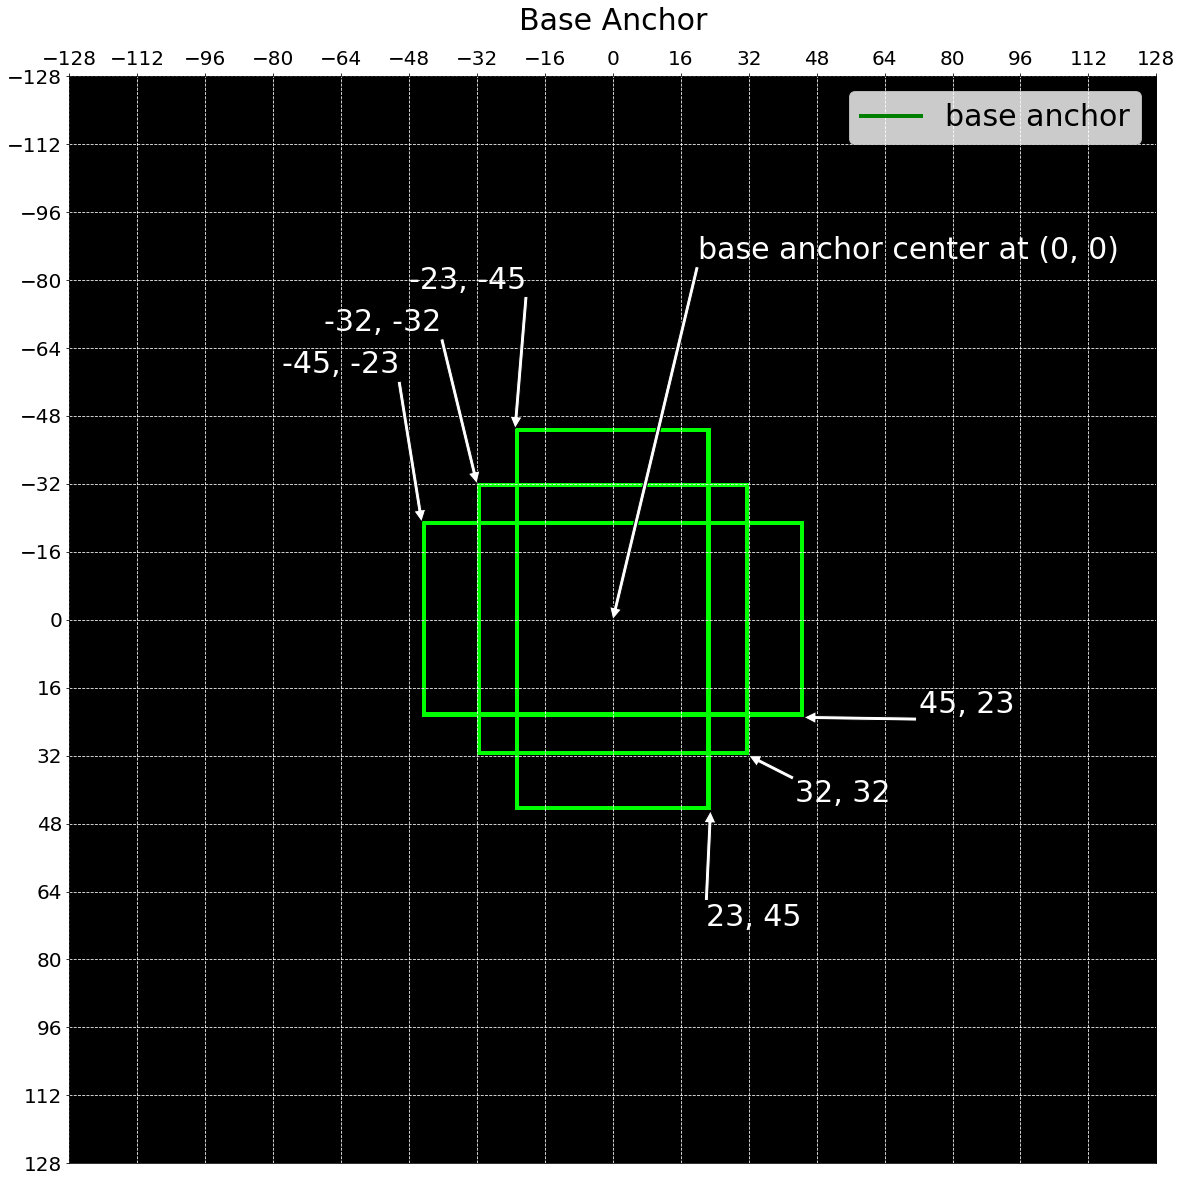

In [5]:
base_anchor = gen_base_anchors(base_size, ratios, scales[:1])
draw_base_anchor_on_grid(base_anchor)

- 각 feature map의 pixel은 원 image 기준 좌표가 있을 것입니다. 이 좌표들에 base anchor를 더해주면 feature map 기준 각 pixel에 base anchor가 존재하게 되고 image 기준으로 stride 만큼 띄엄띄엄 base anchor가 존재하는 것으로 해석할 수 있습니다.
    - feature map 모든 pixel에 할당된 anchor와 이 때 anchor들 간 거리인 `shifts`를 구하고 몇 개의 샘플을 시각화해봅시다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


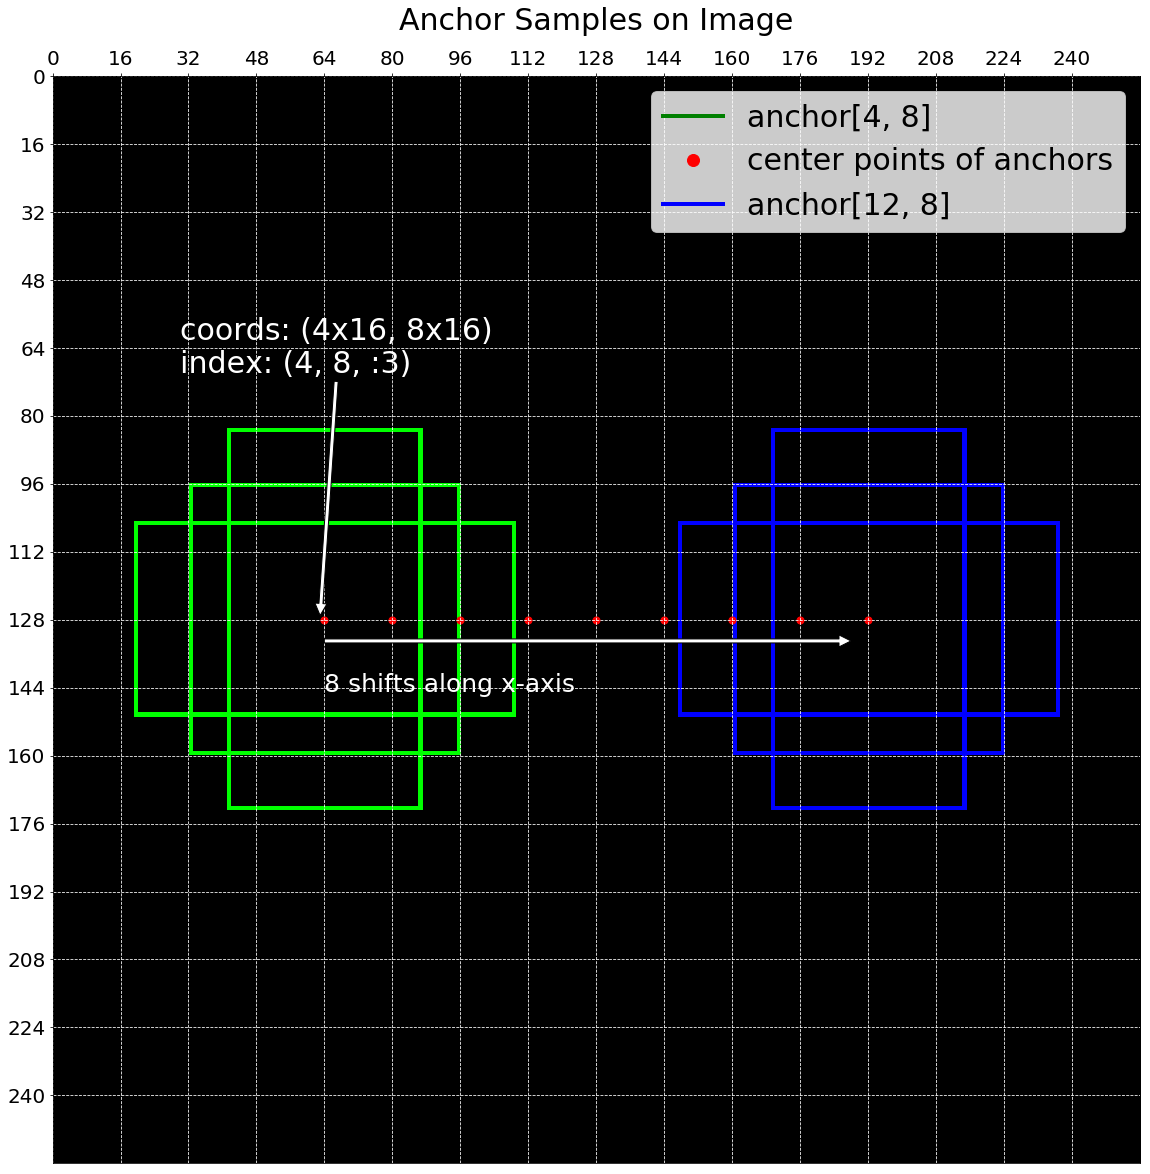

In [6]:
all_anchors, shifts = grid_anchors(base_anchor, featmap_size, anchor_stride, device)
draw_anchor_samples_on_image(image_shape, base_anchor, all_anchors, shifts)

- `get_anchors`라는 함수를 통해 전체 anchor와 각각에 대한 valid 여부를 나타내는 `flag`를 얻습니다.
    - `flag`은 anchor가 이미지를 벗어나거나 할 때 학습에 사용하지 않기 위한 flag 입니다.

In [7]:
anchors, flags = get_anchors(image_shape, featmap_size, base_size, anchor_stride, scales, ratios, device)

In [8]:
assert anchors.shape[0] == featmap_size[0] * featmap_size[1] * 9  # feature map 32x32 각 pixel에 9개의 anchors
assert len(flags) == len(anchors)  # anchor를 사용할 지 말지 결정하는 flags와 anchors의 개수는 같아야 합니다.

## Anchor Selection
anchor는 gt와의 overlap 정도에 따라서 positive, negative를 배정합니다. 이 배정된 값들은 이 후에 regression, classification에 활용되게 됩니다.
- positive는 classification, regression 모두에 활용됩니다. 그래야 특정 bbox에 대해서 object의 class와 영역을 예측할 수 있게 됩니다.
- negative는 classification에만 활용됩니다. 그 이유는 negative의 경우 background라는 정보는 가지고 있지만, 어느 위치에 물체가 있다는 정보는 가지고 있지 않기 때문입니다. [4]
- overlap은 [IoU(Intersection over Union)](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)를 통해 계산합니다.

In [9]:
overlaps = bbox_overlaps(gt_bboxes_list, anchors)  

In [10]:
assert overlaps.shape == (len(gt_bboxes_list), anchors.shape[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


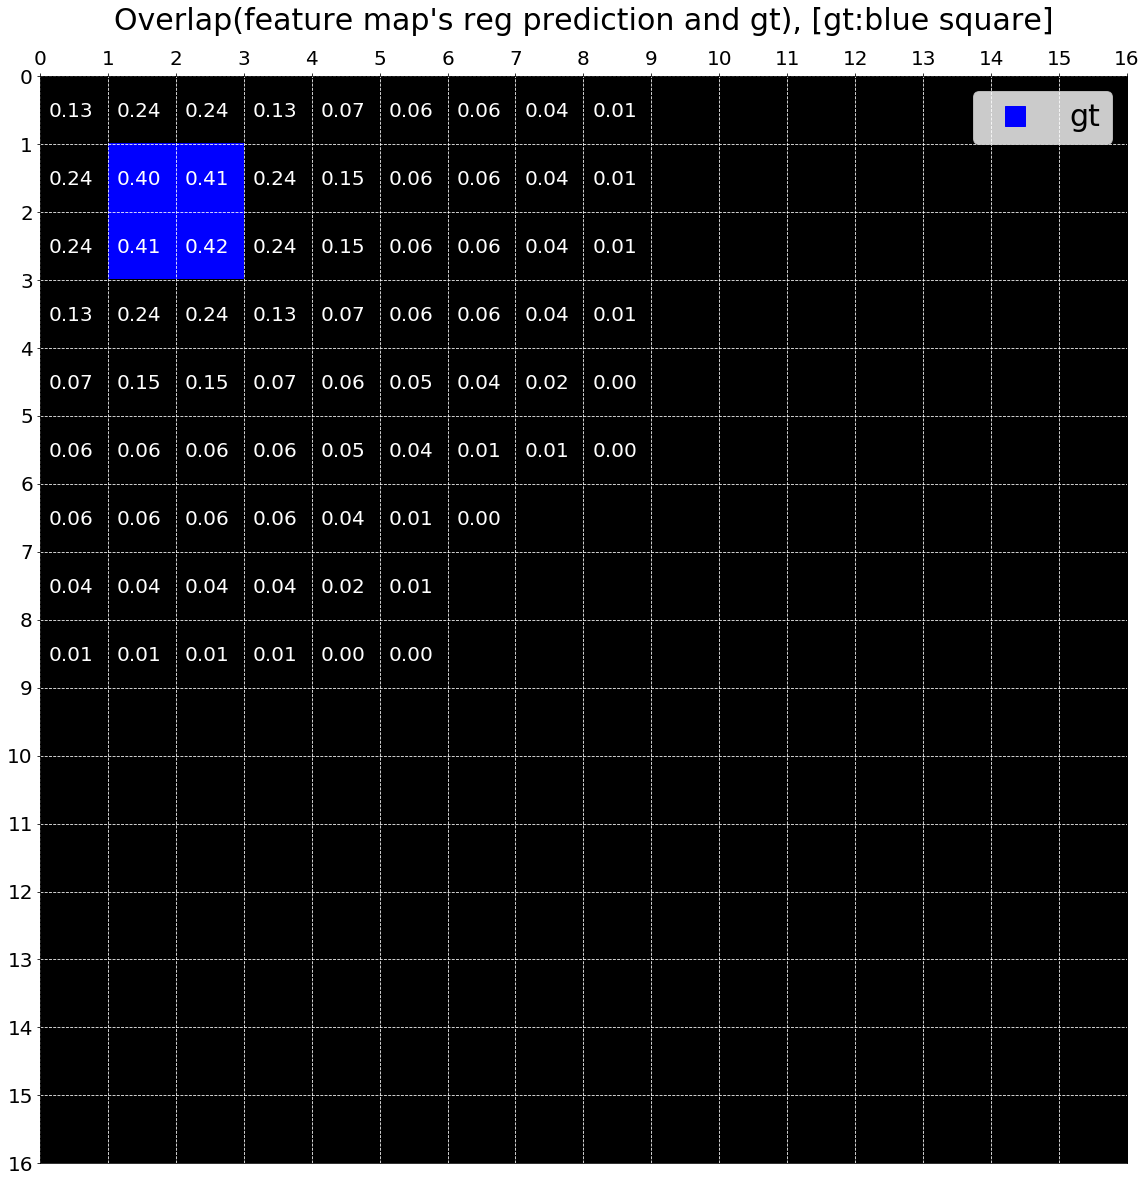

In [11]:
draw_anchor_gt_overlaps(overlaps, gt_bboxes_list, featmap_size, 
                        anchors_per_grid, anchor_stride=anchor_stride, draw_gt=True)

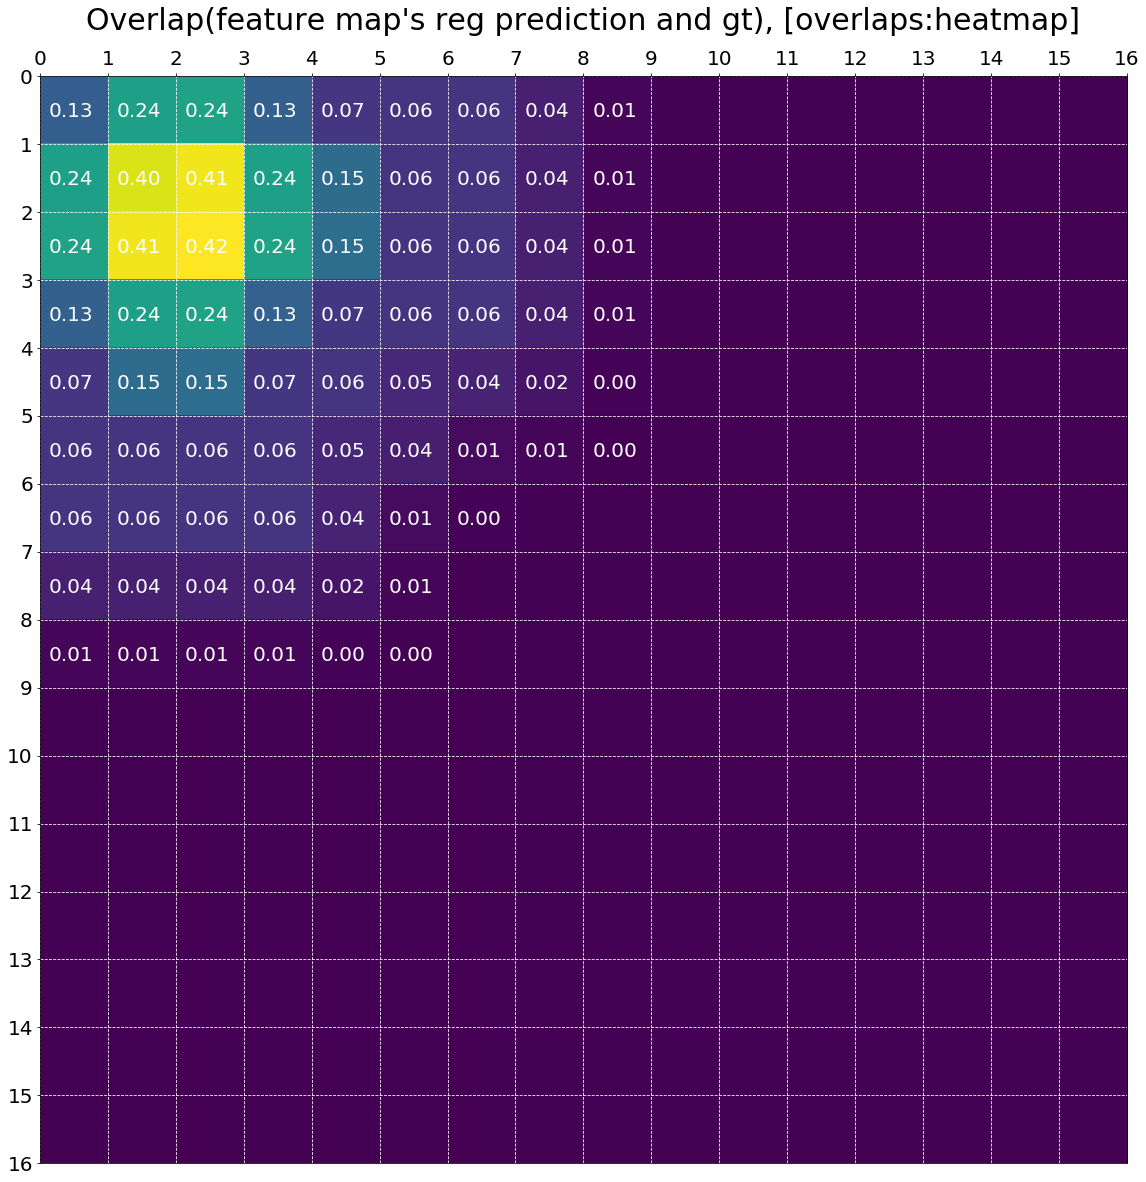

In [12]:
draw_anchor_gt_overlaps(overlaps, gt_bboxes_list, featmap_size, anchors_per_grid, anchor_stride)

In [13]:
# gt와의 overlap에 따라 pos, negative를 배정합니다.
num_gts, assigned_gt_inds, max_overlaps = assign_wrt_overlaps(overlaps)

In [14]:
pos_inds = torch.nonzero(assigned_gt_inds > 0).squeeze(-1).unique()  # positive indices
neg_inds = torch.nonzero(assigned_gt_inds == 0).squeeze(-1).unique()  # negative indices

In [15]:
# positive와 1:1 비율로 학습에 사용할 negative sample을 얻습니다.
sampled_neg_inds = neg_inds[torch.randint(0, len(neg_inds), size=(len(pos_inds), ))]

In [16]:
pos_neg_cls_label = torch.cat([torch.ones(len(pos_inds)), torch.zeros(len(sampled_neg_inds))])

In [17]:
bboxes = anchors  # bboxes
pos_bboxes = bboxes[pos_inds]  # positive boxes
pos_assigned_gt_inds = assigned_gt_inds[pos_inds] - 1
pos_gt_bboxes = gt_bboxes_list[pos_assigned_gt_inds, :]

## Anchor as a Target
**gt-anchor 차이**에 대해서 학습해야 하기 때문에 [5] anchor bbox를 coordination(`[x1, y1, x2, y2]`) 형태에서 target(`target_delta`)으로 변환해주는 과정을 거쳐야 합니다. 

In [18]:
# target_deltas는 특정 pos_inds에 대한 것이며 이 inds에 할당된 anchor를 기준으로만 loss가 계산이 되도록 해야 합니다.
target_deltas = bbox2delta(pos_bboxes, pos_gt_bboxes)

In [19]:
# 변환이 제대로 되었는지 확인합니다. 
bboxes_reversed = delta2bbox(pos_bboxes, target_deltas)
assert torch.equal(bboxes_reversed[0], gt_bboxes_list[0])

## Train anchor
anchor target을 만들었다면 앞에서 나온 feature를 network(`anchor_head`)를 통과시켜 regression 예측 값(reg_pred)으로 delta를 예측하도록, class 예측 값(score)으로 실제 class를 예측하도록 학습시킵니다. 

- loss는 one/two-stage network 마다 다르게 적용되나 공통적으로 regression은 smooth-l1를, classification은 [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy)를 가장 많이 사용합니다.
- loss 계산에는 positive, negative sample을 모두 다 사용할 수는 있지만, positive sample에 비해 negative sample의 개수가 압도적으로 많으므로, 일부 정해진 숫자 만큼만의 sample을 선정하여 학습에 사용합니다.(e.g. positive:negative=1:1.) [5]

- 아래에서 예측 값을 구하는 과정에서 엄밀하게는 anchor prediction을 구하고 그 중에 `pos_inds`에 해당하는 값만 가져오는 과정을 거쳐야 하는데 편의를 위해서 해당 과정을 거쳐서 `pos_delta_pred`를 구했다고 하겠습니다. 
- loss를 구한 뒤에 gradient descent 하는 과정은 생략하겠습니다.

In [20]:
pos_neg_cls_pred, pos_delta_pred = predict_anchors(anchors.shape, target_deltas, sampled_neg_inds)

In [21]:
# regression, class loss를 각각 계산합니다.
reg_loss = smooth_l1_loss(pos_delta_pred, target_deltas, beta=1.0)
print("reg_loss:", reg_loss)
cls_loss = binary_cross_entropy(pos_neg_cls_pred, pos_neg_cls_label)
print("cls_loss:", cls_loss)

reg_loss: tensor(0.0795)
cls_loss: tensor(2.7997)


## Test 
- feature map을 받아 bbox의 cls_pred, reg_pred를 예측할 때 **reg_pred를 delta로 하기 때문에**, delta를 bbox로 변환해주는 과정이 필요합니다.(`delta2bbox`) 
- delta는 **gt-anchor의 차이**이기 때문에 anchor bbox의 coordination 정보를 가지고 있으면 재변환해주는 과정은 수식적으로 풀면 되어 어렵지 않습니다.
- 최종적으로 object 예측 결과는 cls_pred가 특정 threshold 이상인 값들에 대해서 [Non-maximum suppresion(NMS)](https://en.wikipedia.org/wiki/Canny_edge_detector#Non-maximum_suppression)를 통과시킨 결과입니다. 

- `cls_pred` threshold, nms가 모두 고려되었다고 가정하고 위에서 얻은 `pos_delta_pred`를 test 결과로 얻었다고 가정하겠습니다.

In [30]:
pos_bboxes_pred = delta2bbox(pos_bboxes, pos_delta_pred)

아래 그림에서는 positve prediction들에 대해서 예측한 값을 순서대로 나타내었습니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


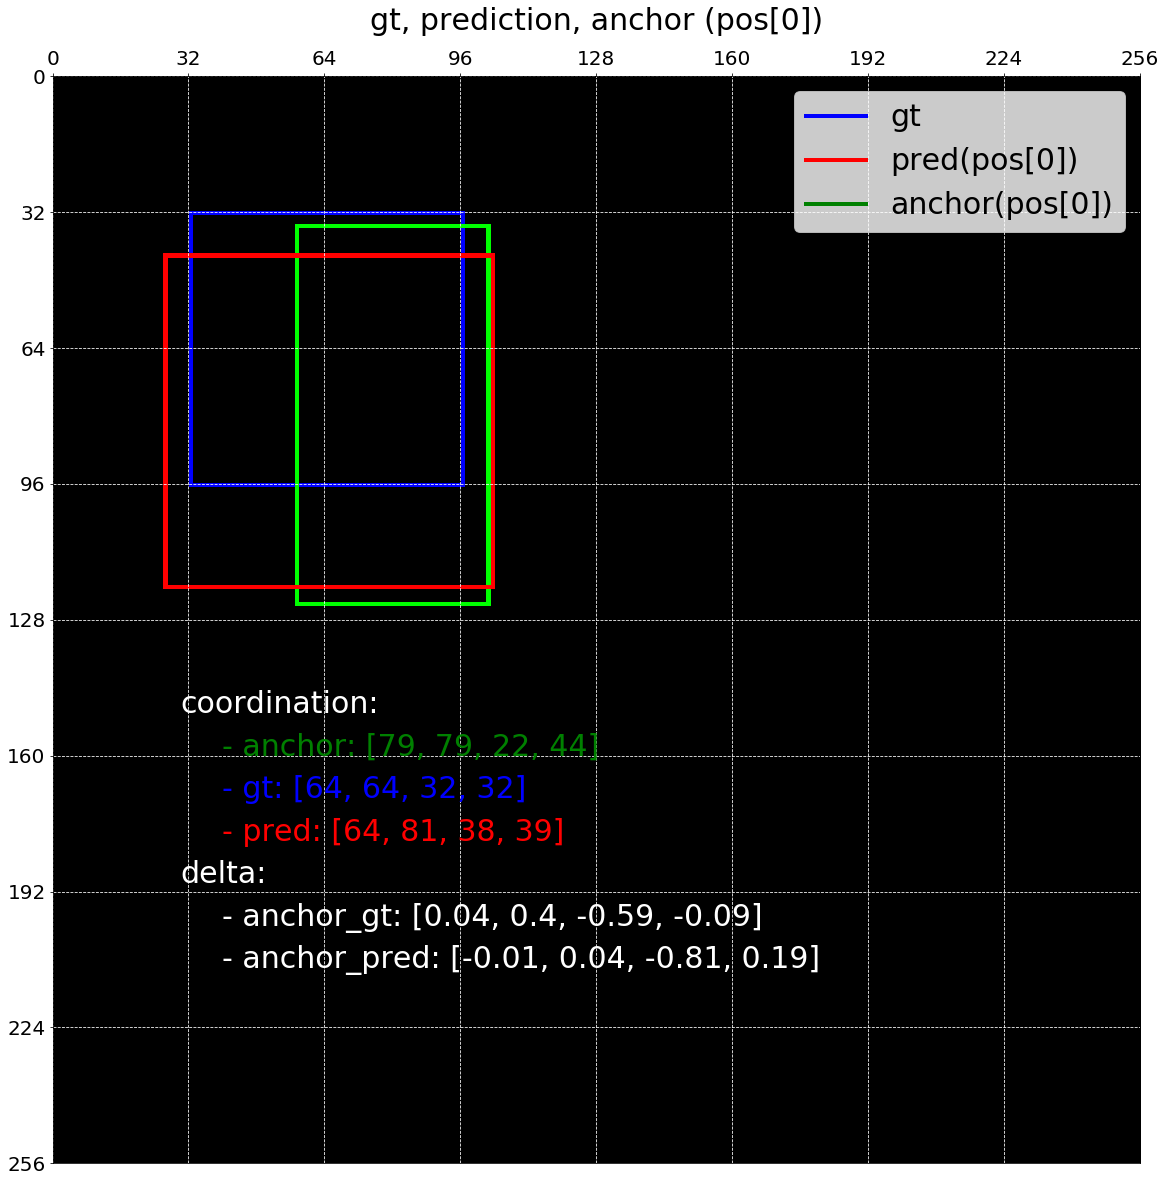

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


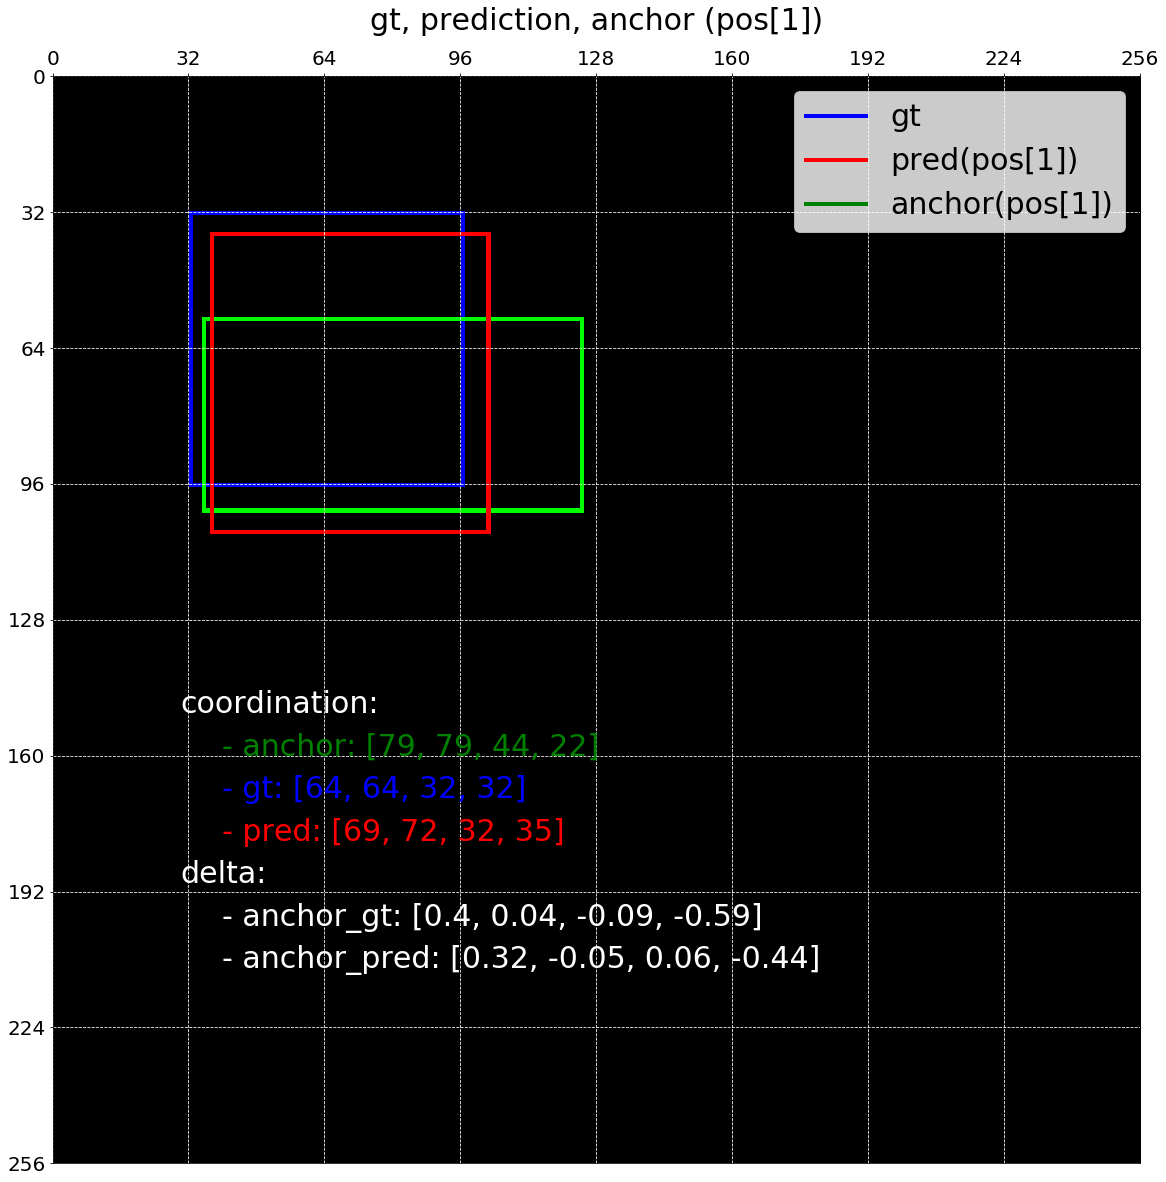

In [31]:
# blue: gt, green: anchor, red: prediction32, 32, 9
draw_pos_assigned_bboxes(image_shape, base_size, gt_bboxes_list, pos_bboxes, pos_bboxes_pred)

## Reference

---
### Faster R-CNN
**[1]** Translation-Invariant Anchors
     An important property of our approach is that it is translation invariant, both in terms of the anchors and the functions that compute proposals relative to the anchors.
     If one translates an object in an image, the proposal should translate and the same function should be able to predict the proposal in either location.

**[2]** Multi-Scale Anchors as Regression References
     Our design of anchors presents a novel scheme for addressing multiple scales (and aspect ratios).
     The second way is to use sliding windows of multiple scales (and/or aspect ratios) on the feature maps.

**[3]** For denser scale coverage than in Faster-RCNN, at each level we add anchors of sizes $\{2^0,2^{\frac 1 3}, 2^{\frac 2 3}\}$ of the original set of $3$ aspect ratio anchors.
     This improve AP in our setting. In total there are $A = 9$ anchors per level and across levels they cover the scale range $32 - 813$ pixels with respect to the network’s input image.

**[4]** For training RPNs, we assign a binary class label (of being an object or not) to each anchor.
     We assign a positive label to two kinds of anchors:
     (i) the anchor/anchors with the highest Intersection-overUnion (IoU) overlap with a ground-truth box, or
     (ii) an anchor that has an IoU overlap higher than $0.7$ with any ground-truth box.
     Note that a single ground-truth box may assign positive labels to multiple anchors.
     We assign a negative label to a non-positive anchor if its IoU ratio is lower than $0.3$ for all ground-truth boxes.
     Anchors that are neither positive nor negative do not contribute to the training objective.

**[5]** For bounding box regression, we adopt the parameterizations of the 4 coordinates following: 
$$ t_x = (x - x_a) / w_a,\ t_y = (y - y_a) / h_a, \\
   t_w = \log(w / w_a),\ t_h = \log(h / h_a), \\
   t_x^{\ast} = (x^{\ast} - x_a) / w_a,\ t_y^{\ast} = (y^{\ast} - y_a) / h_a, \\
   t_w^{\ast} = \log(w^{\ast} / w_a),\ t_h^{\ast} = \log(h^{\ast} / h_a) $$
   
**[6]** It is possible to optimize for the loss functions of all anchors, but this will bias towards negative samples as they are dominate.
     Instead, we randomly sample $256$ anchors in an image to compute the loss function of a mini-batch, where the sampled positive and negative anchors have a ratio of up to $1:1$.

### RetinaNet
**[7]** The design of our RetinaNet detector shares many similarities with previous dense detectors, in particular the concept of 'anchors' introduced by RPN and use of features pyramids as in SSD and FPN. 

**[8]** We use translation-invariant anchor boxes similar to those in the RPN variant. The anchors have areas of $32^2$ to $512^2$ on pyramid levels $P_3$ to $P_7$, respectively. at each pyramid level we use anchors at three aspect ratios $\{1:2, 1:1, 2:1\}$. For denser scale coverage, at each level we add anchors of sizes $\{2^0, 2^{1/3}, 2^{2/3}\}$ of the original set of 3 aspect ratio anchors. This improve AP in our setting. In total there are $A=9$ anchors per level and across levels they cover the scale range $32-813$ pixels with respect to the network's input image. Each anchor is assigned a length $K$ one-hot vector of classification targets, where $K$ is the number of object classes, and a $4$-vector of box regression targets. We use the assignment rule from RPN but modified for multi-class detection and with adjusted thresholds. Specifically, anchors are assigned to ground-truth object boxes using an intersection-over-union(IoU) threshold of $0.5$; and to background if their IoU is in $[0, 0.4)$. As each anchor is assigned to at most one object box, we set the corresponding entry in its length $K$ label vector to $1$ and all other entries to $0$. If an anchor is unassigned, which may happen with overlap in $[0.4, 0.5)$, it is ignored during training. Box regression targets are computed as the offset between each anchor and its assigned object box, or omitted if there is no assignment.

**[9]** The classification subnet predicts the probability of object presence at each spatial position for each of the $A$ anchors and $K$ object classes.

**[10]** In parallel with the object classification subnet, we attach another small FCN to each pyramid level for the purpose of regressing the offset from each anchor box to a nearby ground-truth object, if one exists. For each of the $A$ anchors per spatial location, these $4$ outputs predict the relative offset between the anchor and the ground-truth box.